In [1]:
from brian2 import *
from numpy import linspace
from random import randint
from random import choice
start_scope()

INFO       Cache size for target "cython": 14327 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "C:\Users\cambo\.cython\brian_extensions" directory. [brian2]


In [2]:
# populations
N = 1500
N_E = int(N * 0.8)  # pyramidal neurons
N_I = int(N * 0.2)  # interneurons
sub_N_E = int(N_E/3)
sub_N_I = int(N_I/3)

#Spatial paramaters
r_exci = (N_E/(2*pi))*umetre
r_inhib = (N_I/(2*pi))*umetre

# voltage
V_L = -70. * mV
V_thr = -50. * mV
V_reset = -55. * mV
V_E = 0. * mV
V_I = -70. * mV

# membrane capacitance
C_m_E_init = 0.5 * nF
C_m_E_min = 0.25 * nF
C_m_I = 0.2 * nF

# membrane leak
g_m_E = 25. * nS
g_m_I = 20. * nS

# refractory period
tau_rp_E = 2. * ms
tau_rp_I = 1. * ms

# external stimuli
rate = 1.5 * Hz
C_ext = 1200

# synapses
C_E = N_E
C_I = N_I

# AMPA (excitatory)
g_AMPA_ext_E = 2.08 * nS
g_AMPA_rec_E = 0.104 * nS * 800. / N_E
g_AMPA_ext_I = 1.62 * nS
g_AMPA_rec_I = 0.081 * nS * 800. / N_E
tau_AMPA = 2. * ms

# NMDA (excitatory)
g_NMDA_E = 0.327 * nS * 800. / N_E
g_NMDA_I = 0.258 * nS * 800. / N_E
tau_NMDA_rise = 2. * ms
tau_NMDA_decay = 100. * ms
alpha = 0.5 / ms
Mg2 = 1.

# GABAergic (inhibitory)
g_GABA_E = 1.25 * nS * 200. / N_I
g_GABA_I = 0.973 * nS * 200. / N_I
tau_GABA = 10. * ms

# subpopulations
f = 0.1
p = 5
N_sub_sub = int(N_E*(2/3) * f)
N_non = int(N_E*(2/3) * (1. - f * p))
w_plus = 2.1
w_minus = 1. - f * (w_plus - 1.) / (1. - f)

In [3]:
# neurons equation

eqs_E = '''
dv / dt = (- g_m_E * (v - V_L) - I_syn) / C_m_E : volt (unless refractory)

I_syn = I_AMPA_ext + I_AMPA_rec + I_NMDA_rec + I_GABA_rec : amp

I_AMPA_ext = g_AMPA_ext_E * (v - V_E) * s_AMPA_ext : amp
I_AMPA_rec = g_AMPA_rec_E * (v - V_E) * 1 * s_AMPA : amp
ds_AMPA_ext / dt = - s_AMPA_ext / tau_AMPA : 1
ds_AMPA / dt = - s_AMPA / tau_AMPA : 1

I_NMDA_rec = g_NMDA_E * (v - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp
s_NMDA_tot = s_NMDA_tot_sensory + s_NMDA_tot_PFC : 1
s_NMDA_tot_sensory : 1
s_NMDA_tot_PFC : 1


I_GABA_rec = g_GABA_E * (v - V_I) * s_GABA : amp
ds_GABA / dt = - s_GABA / tau_GABA : 1
C_m_E : farad

x_distant : metre
y_distant : metre
'''

eqs_I = '''
dv / dt = (- g_m_I * (v - V_L) - I_syn) / C_m_I : volt (unless refractory)

I_syn = I_AMPA_ext + I_AMPA_rec + I_NMDA_rec + I_GABA_rec : amp

I_AMPA_ext = g_AMPA_ext_I * (v - V_E) * s_AMPA_ext : amp
I_AMPA_rec = g_AMPA_rec_I * (v - V_E) * 1 * s_AMPA : amp
ds_AMPA_ext / dt = - s_AMPA_ext / tau_AMPA : 1
ds_AMPA / dt = - s_AMPA / tau_AMPA : 1

I_NMDA_rec = g_NMDA_I * (v - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp
s_NMDA_tot = s_NMDA_tot_sensory + s_NMDA_tot_PFC : 1
s_NMDA_tot_sensory : 1
s_NMDA_tot_PFC : 1


I_GABA_rec = g_GABA_I * (v - V_I) * s_GABA : amp
ds_GABA / dt = - s_GABA / tau_GABA : 1

x_distant : metre
y_distant : metre
'''


In [4]:
# Neurons population

# Sensory
#No selectivity
S_E_NO = NeuronGroup(sub_N_E, eqs_E, threshold='v > V_thr', reset='v = V_reset', refractory=tau_rp_E, method='euler')
S_E_NO.v = V_L
S_E_NO.C_m_E = C_m_E_init
S_I_NO = NeuronGroup(sub_N_I, eqs_I, threshold='v > V_thr', reset='v = V_reset', refractory=tau_rp_I, method='euler')
S_I_NO.v = V_L

#Orientation selectivity
S_E_OR = NeuronGroup(sub_N_E, eqs_E, threshold='v > V_thr', reset='v = V_reset', refractory=tau_rp_E, method='euler')
S_E_OR.v = V_L
S_E_OR.C_m_E = C_m_E_init
S_I_OR = NeuronGroup(sub_N_I, eqs_I, threshold='v > V_thr', reset='v = V_reset', refractory=tau_rp_I, method='euler')
S_I_OR.v = V_L

#Color selectivity
S_E_CO = NeuronGroup(sub_N_E, eqs_E, threshold='v > V_thr', reset='v = V_reset', refractory=tau_rp_E, method='euler')
S_E_CO.v = V_L
S_E_CO.C_m_E = C_m_E_init
S_I_CO = NeuronGroup(sub_N_I, eqs_I, threshold='v > V_thr', reset='v = V_reset', refractory=tau_rp_I, method='euler')
S_I_CO.v = V_L


# PFC
#No selectivity
PFC_E_NO = NeuronGroup(sub_N_E, eqs_E, threshold='v > V_thr', reset='v = V_reset', refractory=tau_rp_E, method='euler')
PFC_E_NO.v = V_L
PFC_E_NO.C_m_E = C_m_E_init
PFC_I_NO = NeuronGroup(sub_N_I, eqs_I, threshold='v > V_thr', reset='v = V_reset', refractory=tau_rp_I, method='euler')
PFC_I_NO.v = V_L

#Orientation selectivity
PFC_E_OR = NeuronGroup(sub_N_E, eqs_E, threshold='v > V_thr', reset='v = V_reset', refractory=tau_rp_E, method='euler')
PFC_E_OR.v = V_L
PFC_E_OR.C_m_E = C_m_E_init
PFC_I_OR = NeuronGroup(sub_N_I, eqs_I, threshold='v > V_thr', reset='v = V_reset', refractory=tau_rp_I, method='euler')
PFC_I_OR.v = V_L

#Color selectivity
PFC_E_CO = NeuronGroup(sub_N_E, eqs_E, threshold='v > V_thr', reset='v = V_reset', refractory=tau_rp_E, method='euler')
PFC_E_CO.v = V_L
PFC_E_CO.C_m_E = C_m_E_init
PFC_I_CO = NeuronGroup(sub_N_I, eqs_I, threshold='v > V_thr', reset='v = V_reset', refractory=tau_rp_I, method='euler')
PFC_I_CO.v = V_L


In [5]:
# Position
S_E_NO.x_distant = '(r_exci) * cos ((i * 2 * pi) /sub_N_E )'
S_E_NO.y_distant = '(r_exci) * sin ((i * 2 * pi) /sub_N_E )'
S_I_NO.x_distant = '(r_inhib)* cos ((i * 2 * pi) / sub_N_I)'
S_I_NO.y_distant = '(r_inhib)* sin ((i * 2 * pi) / sub_N_I)'

S_E_OR.x_distant = '(r_exci) * cos ((i * 2 * pi) /sub_N_E )'
S_E_OR.y_distant = '(r_exci) * sin ((i * 2 * pi) /sub_N_E )'
S_I_OR.x_distant = '(r_inhib)* cos ((i * 2 * pi) / sub_N_I)'
S_I_OR.y_distant = '(r_inhib)* sin ((i * 2 * pi) / sub_N_I)'

S_E_CO.x_distant = '(r_exci) * cos ((i * 2 * pi) /sub_N_E )'
S_E_CO.y_distant = '(r_exci) * sin ((i * 2 * pi) /sub_N_E )'
S_I_CO.x_distant = '(r_inhib)* cos ((i * 2 * pi) / sub_N_I)'
S_I_CO.y_distant = '(r_inhib)* sin ((i * 2 * pi) / sub_N_I)'

neuron_spacing_ex = sqrt((S_E_NO.x_distant[0]-S_E_NO.x_distant[1])**2+(S_E_NO.y_distant[0]-S_E_NO.y_distant[1])**2)
neuron_spacing_in = sqrt((S_I_NO.x_distant[0]-S_I_NO.x_distant[1])**2+(S_I_NO.y_distant[0]-S_I_NO.y_distant[1])**2)
neuron_spacing_ex_in = sqrt((S_I_NO.x_distant[0]-S_E_NO.x_distant[0])**2+(S_I_NO.y_distant[0]-S_E_NO.y_distant[0])**2)


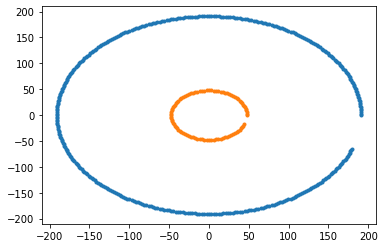

In [6]:
plot(S_E_NO.x_distant[0:379]/um,S_E_NO.y_distant[0:379]/um,'.')
plot(S_I_NO.x_distant[0:95]/um,S_I_NO.y_distant[0:95]/um,'.')

In [7]:
# synapses equation
eqs_glut_PFC = '''
s_NMDA_tot_PFC_post= w * s_NMDA : 1 (summed)
ds_NMDA / dt = - s_NMDA / tau_NMDA_decay + alpha * x * (1 - s_NMDA) : 1 (clock-driven)
dx / dt = - x / tau_NMDA_rise : 1 (clock-driven)
w : 1
'''

eqs_glut_sensory = '''
s_NMDA_tot_sensory_post = w * s_NMDA : 1 (summed)
ds_NMDA / dt = - s_NMDA / tau_NMDA_decay + alpha * x * (1 - s_NMDA) : 1 (clock-driven)
dx / dt = - x / tau_NMDA_rise : 1 (clock-driven)
w : 1
'''

eqs_pre_glut = '''
s_AMPA += w
x += 1
'''

eqs_pre_gaba = '''
s_GABA += 1
'''

eqs_pre_ext = '''
s_AMPA_ext += 1
'''

eqs_post_poten ='''
C_m_E = clip(C_m_E - 5.2 * pF,C_m_E_min,C_m_E_init) 
'''

In [8]:
# Sensory connection

# inhibitor to excitator No selectivity
S_I_S_E_NO = Synapses(S_I_NO,S_E_NO,'w : 1' ,on_pre='s_GABA += w', method='euler')
S_I_S_E_NO.connect()
S_I_S_E_NO.w = '2.6*((1/(sqrt(2*pi))) * exp(-0.5 *(sqrt((x_distant_pre-x_distant_post)**2+(y_distant_pre-y_distant_post)**2)/neuron_spacing_ex_in)**2))'

# inhibitor to excitator Orientation selectivity
S_I_S_E_OR = Synapses(S_I_OR,S_E_OR,'w : 1' ,on_pre='s_GABA += w', method='euler')
S_I_S_E_OR.connect()
S_I_S_E_OR.w = '2.6*((1/(sqrt(2*pi))) * exp(-0.5 *(sqrt((x_distant_pre-x_distant_post)**2+(y_distant_pre-y_distant_post)**2)/neuron_spacing_ex_in)**2))'

# inhibitor to excitator Color selectivity
S_I_S_E_CO = Synapses(S_I_CO,S_E_CO,'w : 1' ,on_pre='s_GABA += w', method='euler')
S_I_S_E_CO.connect()
S_I_S_E_CO.w = '2.6*((1/(sqrt(2*pi))) * exp(-0.5 *(sqrt((x_distant_pre-x_distant_post)**2+(y_distant_pre-y_distant_post)**2)/neuron_spacing_ex_in)**2))'

# inhibitor to inhibitor No selectivity
S_I_S_I_NO = Synapses(S_I_NO, S_I_NO, on_pre=eqs_pre_gaba, method='euler')
S_I_S_I_NO.connect(condition='i != j')

# inhibitor to inhibitor Orientation selectivity
S_I_S_I_OR = Synapses(S_I_OR, S_I_OR, on_pre=eqs_pre_gaba, method='euler')
S_I_S_I_OR.connect(condition='i != j')

# inhibitor to inhibitor Color selectivity
S_I_S_I_CO = Synapses(S_I_CO, S_I_CO, on_pre=eqs_pre_gaba, method='euler')
S_I_S_I_CO.connect(condition='i != j')

In [9]:
# Sensory to Working memory
#No selectivity
S_E_PFC_E_NO = Synapses(S_E_NO,PFC_E_NO,model=eqs_glut_sensory, on_pre=eqs_pre_glut, method='euler')
S_E_PFC_E_NO.connect('i == j')
S_E_PFC_E_NO.w[:] = 261

#Orientation selectivity
S_E_PFC_E_OR = Synapses(S_E_OR,PFC_E_OR,model=eqs_glut_sensory, on_pre=eqs_pre_glut, method='euler')
S_E_PFC_E_OR.connect('i == j')
S_E_PFC_E_OR.w[:] = 261

#Color selectivity
S_E_PFC_E_CO = Synapses(S_E_CO,PFC_E_CO,model=eqs_glut_sensory, on_pre=eqs_pre_glut, method='euler')
S_E_PFC_E_CO.connect('i == j')
S_E_PFC_E_CO.w[:] = 261

In [10]:
# Working memory connection

# excitator to excitator No selectivity
C_E_E_NO = Synapses(PFC_E_NO, PFC_E_NO, model=eqs_glut_PFC, on_pre=eqs_pre_glut, method='euler')
C_E_E_NO.connect(condition='i != j')
C_E_E_NO.w[:] = 1

# excitator to excitator Orientation selectivity
C_E_E_OR = Synapses(PFC_E_OR , PFC_E_OR , model=eqs_glut_PFC, on_pre=eqs_pre_glut, method='euler')
C_E_E_OR.connect(condition='i != j')
C_E_E_OR.w[:] = 1

# excitator to excitator Color selectivity
C_E_E_CO = Synapses(PFC_E_CO, PFC_E_CO, model=eqs_glut_PFC, on_pre=eqs_pre_glut, method='euler')
C_E_E_CO.connect(condition='i != j')
C_E_E_CO.w[:] = 1


for pi in range(0, sub_N_E, N_sub_sub):

    # internal other subpopulation to current nonselective
    C_E_E_OR.w[C_E_E_OR.indices[:, pi:pi + N_sub_sub]] = w_minus
    C_E_E_CO.w[C_E_E_CO.indices[:, pi:pi + N_sub_sub]] = w_minus

    # internal current subpopulation to current subpopulation
    C_E_E_OR.w[C_E_E_OR.indices[pi:pi + N_sub_sub, pi:pi + N_sub_sub]] = w_plus
    C_E_E_CO.w[C_E_E_CO.indices[pi:pi + N_sub_sub, pi:pi + N_sub_sub]] = w_plus

C_E_E_NO.w[:] = C_E_E_NO.w[:] * 5.4
C_E_E_OR.w[:] = C_E_E_OR.w[:] * 5.4
C_E_E_CO.w[:] = C_E_E_CO.w[:] * 5.4


# excitator to inhibitor No selectivity
C_E_I_NO = Synapses(PFC_E_NO, PFC_I_NO, model=eqs_glut_PFC, on_pre=eqs_pre_glut, method='euler')
C_E_I_NO.connect()
C_E_I_NO.w[:] = 9

# excitator to inhibitor Orientation selectivity
C_E_I_OR = Synapses(PFC_E_OR, PFC_I_OR, model=eqs_glut_PFC, on_pre=eqs_pre_glut, method='euler')
C_E_I_OR.connect()
C_E_I_OR.w[:] = 9

# excitator to inhibitor Color selectivity
C_E_I_CO = Synapses(PFC_E_CO, PFC_I_CO, model=eqs_glut_PFC, on_pre=eqs_pre_glut, method='euler')
C_E_I_CO.connect()
C_E_I_CO.w[:] = 9



# inhibitor to inhibitor No selectivity
C_I_I_NO = Synapses(PFC_I_NO, PFC_I_NO, on_pre=eqs_pre_gaba, method='euler')
C_I_I_NO.connect(condition='i != j')

# inhibitor to inhibitor Orientation selectivity
C_I_I_OR = Synapses(PFC_I_OR, PFC_I_OR, on_pre=eqs_pre_gaba, method='euler')
C_I_I_OR.connect(condition='i != j')

# inhibitor to inhibitor Color selectivity
C_I_I_CO = Synapses(PFC_I_CO, PFC_I_CO, on_pre=eqs_pre_gaba, method='euler')
C_I_I_CO.connect(condition='i != j')



# inhibitor to excitator No selectivity
C_I_E_NO = Synapses(PFC_I_NO, PFC_E_NO, on_pre=eqs_pre_gaba, method='euler')
C_I_E_NO.connect()

# inhibitor to excitator Orientation selectivity
C_I_E_OR = Synapses(PFC_I_OR, PFC_E_OR, on_pre=eqs_pre_gaba, method='euler')
C_I_E_OR.connect()

# inhibitor to excitator Color selectivity
C_I_E_CO = Synapses(PFC_I_CO, PFC_E_CO, on_pre=eqs_pre_gaba, method='euler')
C_I_E_CO.connect()

In [11]:
# working to sensory

# E to Sensory I
C_E_S_I_NO = Synapses(PFC_E_NO, S_I_NO, model=eqs_glut_PFC, on_pre=eqs_pre_glut, method='euler')
C_E_S_I_OR = Synapses(PFC_E_OR, S_I_OR, model=eqs_glut_PFC, on_pre=eqs_pre_glut, method='euler')
C_E_S_I_CO = Synapses(PFC_E_CO, S_I_CO, model=eqs_glut_PFC, on_pre=eqs_pre_glut, method='euler')

inhib2=0
for fui2 in range(0,sub_N_E,N_sub_sub):
    inuior = int(sub_N_I*((p-1)/p)-1 +(sub_N_I/p)*inhib2)
    for youpo in range (fui2,fui2+N_sub_sub,int(N_sub_sub/(sub_N_I*(2/5)))):
        if inuior > 99:
            inuior = inuior - 100
        elif inuior < 0:
            inuior = 99
        C_E_S_I_NO.connect (i=(youpo,youpo+1), j=inuior)
        C_E_S_I_OR.connect (i=(youpo,youpo+1), j=inuior)
        C_E_S_I_CO.connect (i=(youpo,youpo+1), j=inuior)
        inuior -= 1
    inhib2+=1
C_E_S_I_NO.w[:]=57
C_E_S_I_OR.w[:]=57
C_E_S_I_CO.w[:]=57

# E to Sensory E
C_E_S_E_NO = Synapses(PFC_E_NO, S_E_NO, on_post=eqs_post_poten, method='euler')
C_E_S_E_NO.connect('i == j')

C_E_S_E_OR = Synapses(PFC_E_OR , S_E_OR , on_post=eqs_post_poten, method='euler')
C_E_S_E_OR.connect('i == j')

C_E_S_E_CO = Synapses(PFC_E_CO, S_E_CO, on_post=eqs_post_poten, method='euler')
C_E_S_E_CO.connect('i == j')

In [12]:
# external noise
C_S_E_NO = PoissonInput(target = S_E_NO, target_var = 's_AMPA_ext', N = C_ext, rate = rate, weight = '1') 
C_S_E_OR = PoissonInput(target = S_E_OR, target_var = 's_AMPA_ext', N = C_ext, rate = rate, weight = '1')
C_S_E_CO = PoissonInput(target = S_E_CO, target_var = 's_AMPA_ext', N = C_ext, rate = rate, weight = '1')

C_S_I_NO = PoissonInput(target = S_I_NO, target_var = 's_AMPA_ext', N = C_ext, rate = rate, weight = '1') 
C_S_I_OR = PoissonInput(target = S_I_OR, target_var = 's_AMPA_ext', N = C_ext, rate = rate, weight = '1')
C_S_I_CO = PoissonInput(target = S_I_CO, target_var = 's_AMPA_ext', N = C_ext, rate = rate, weight = '1')


In [13]:
# monitors

#sp_S_E_sels = [SpikeMonitor(S_E[pi:pi + N_activity_plot]) for pi in range(N_non, N_E, N_sub_sub)]
sp_S_E_sel_orien_1 = SpikeMonitor(S_E_OR[: N_sub_sub - 1])
sp_S_E_sel_orien_2 = SpikeMonitor(S_E_OR[N_sub_sub : 2 * N_sub_sub -1 ])
sp_S_E_sel_orien_3 = SpikeMonitor(S_E_OR[2 * N_sub_sub : 3 * N_sub_sub - 1])
sp_S_E_sel_orien_4 = SpikeMonitor(S_E_OR[3 * N_sub_sub : 4 * N_sub_sub - 1])
sp_S_E_sel_orien_5 = SpikeMonitor(S_E_OR[4 * N_sub_sub : sub_N_E - 1])
sp_S_E_sel_col_1 = SpikeMonitor(S_E_CO[: N_sub_sub - 1])
sp_S_E_sel_col_2 = SpikeMonitor(S_E_CO[N_sub_sub : 2 * N_sub_sub -1])
sp_S_E_sel_col_3 = SpikeMonitor(S_E_CO[2 * N_sub_sub : 3 * N_sub_sub - 1])
sp_S_E_sel_col_4 = SpikeMonitor(S_E_CO[3 * N_sub_sub : 4 * N_sub_sub - 1])
sp_S_E_sel_col_5 = SpikeMonitor(S_E_CO[4 * N_sub_sub : sub_N_E - 1])
sp_S_E = SpikeMonitor(S_E_NO)
sp_S_I_1 = SpikeMonitor(S_I_NO)
sp_S_I_2 = SpikeMonitor(S_I_OR)
sp_S_I_3 = SpikeMonitor(S_I_CO)


#r_S_E_sels = [PopulationRateMonitor(S_E[pi:pi + N_sub_sub]) for pi in range(N_non, N_E, N_sub_sub)]
r_S_E_sel_orien_1 = PopulationRateMonitor(S_E_OR[: N_sub_sub - 1])
r_S_E_sel_orien_2 = PopulationRateMonitor(S_E_OR[N_sub_sub : 2 * N_sub_sub -1 ])
r_S_E_sel_orien_3 = PopulationRateMonitor(S_E_OR[2 * N_sub_sub : 3 * N_sub_sub - 1])
r_S_E_sel_orien_4 = PopulationRateMonitor(S_E_OR[3 * N_sub_sub : 4 * N_sub_sub - 1])
r_S_E_sel_orien_5 = PopulationRateMonitor(S_E_OR[4 * N_sub_sub : sub_N_E - 1])
r_S_E_sel_col_1 = PopulationRateMonitor(S_E_CO[: N_sub_sub - 1])
r_S_E_sel_col_2 = PopulationRateMonitor(S_E_CO[N_sub_sub : 2 * N_sub_sub -1])
r_S_E_sel_col_3 = PopulationRateMonitor(S_E_CO[2 * N_sub_sub : 3 * N_sub_sub - 1])
r_S_E_sel_col_4 = PopulationRateMonitor(S_E_CO[3 * N_sub_sub : 4 * N_sub_sub - 1])
r_S_E_sel_col_5 = PopulationRateMonitor(S_E_CO[4 * N_sub_sub : sub_N_E - 1])
r_S_E = PopulationRateMonitor(S_E_NO)
r_S_I_1 = PopulationRateMonitor(S_I_NO)
r_S_I_2 = PopulationRateMonitor(S_I_OR)
r_S_I_3 = PopulationRateMonitor(S_I_CO)


#sp_E_sels = [SpikeMonitor(PFC_E[pi:pi + N_activity_plot]) for pi in range(N_non, N_E, N_sub_sub)]
sp_E_sel_orien_1 = SpikeMonitor(PFC_E_OR[: N_sub_sub - 1])
sp_E_sel_orien_2 = SpikeMonitor(PFC_E_OR[N_sub_sub : 2 * N_sub_sub -1 ])
sp_E_sel_orien_3 = SpikeMonitor(PFC_E_OR[2 * N_sub_sub : 3 * N_sub_sub - 1])
sp_E_sel_orien_4 = SpikeMonitor(PFC_E_OR[3 * N_sub_sub : 4 * N_sub_sub - 1])
sp_E_sel_orien_5 = SpikeMonitor(PFC_E_OR[4 * N_sub_sub : sub_N_E - 1])
sp_E_sel_col_1 = SpikeMonitor(PFC_E_CO[: N_sub_sub - 1])
sp_E_sel_col_2 = SpikeMonitor(PFC_E_CO[N_sub_sub : 2 * N_sub_sub -1 ])
sp_E_sel_col_3 = SpikeMonitor(PFC_E_CO[2 * N_sub_sub : 3 * N_sub_sub - 1])
sp_E_sel_col_4 = SpikeMonitor(PFC_E_CO[3 * N_sub_sub : 4 * N_sub_sub - 1])
sp_E_sel_col_5 = SpikeMonitor(PFC_E_CO[4 * N_sub_sub : sub_N_E - 1])
sp_E = SpikeMonitor(PFC_E_NO)
sp_I_1 = SpikeMonitor(PFC_I_NO)
sp_I_2 = SpikeMonitor(PFC_I_OR)
sp_I_3 = SpikeMonitor(PFC_I_CO)


#r_E_sels = [PopulationRateMonitor(PFC_E[pi:pi + N_sub_sub]) for pi in range(N_non, N_E, N_sub_sub)]
r_E_sel_orien_1 = PopulationRateMonitor(PFC_E_OR[: N_sub_sub - 1])
r_E_sel_orien_2 = PopulationRateMonitor(PFC_E_OR[N_sub_sub : 2 * N_sub_sub -1])
r_E_sel_orien_3 = PopulationRateMonitor(PFC_E_OR[2 * N_sub_sub : 3 * N_sub_sub - 1])
r_E_sel_orien_4 = PopulationRateMonitor(PFC_E_OR[3 * N_sub_sub : 4 * N_sub_sub - 1])
r_E_sel_orien_5 = PopulationRateMonitor(PFC_E_OR[4 * N_sub_sub : sub_N_E - 1])
r_E_sel_col_1 = PopulationRateMonitor(PFC_E_CO[: N_sub_sub - 1])
r_E_sel_col_2 = PopulationRateMonitor(PFC_E_CO[N_sub_sub : 2 * N_sub_sub -1])
r_E_sel_col_3 = PopulationRateMonitor(PFC_E_CO[2 * N_sub_sub : 3 * N_sub_sub - 1])
r_E_sel_col_4 = PopulationRateMonitor(PFC_E_CO[3 * N_sub_sub : 4 * N_sub_sub - 1])
r_E_sel_col_5 = PopulationRateMonitor(PFC_E_CO[4 * N_sub_sub : sub_N_E - 1])
r_E = PopulationRateMonitor(PFC_E_NO)
r_I_1 = PopulationRateMonitor(PFC_I_NO)
r_I_2 = PopulationRateMonitor(PFC_I_OR)
r_I_3 = PopulationRateMonitor(PFC_I_CO)



In [14]:
# simulate
net = Network(collect())
net.store()

0
2
4
1
le nombre de stimulus est  5


WARNING    C:\Users\cambo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]


pas de spike PFC non selectif


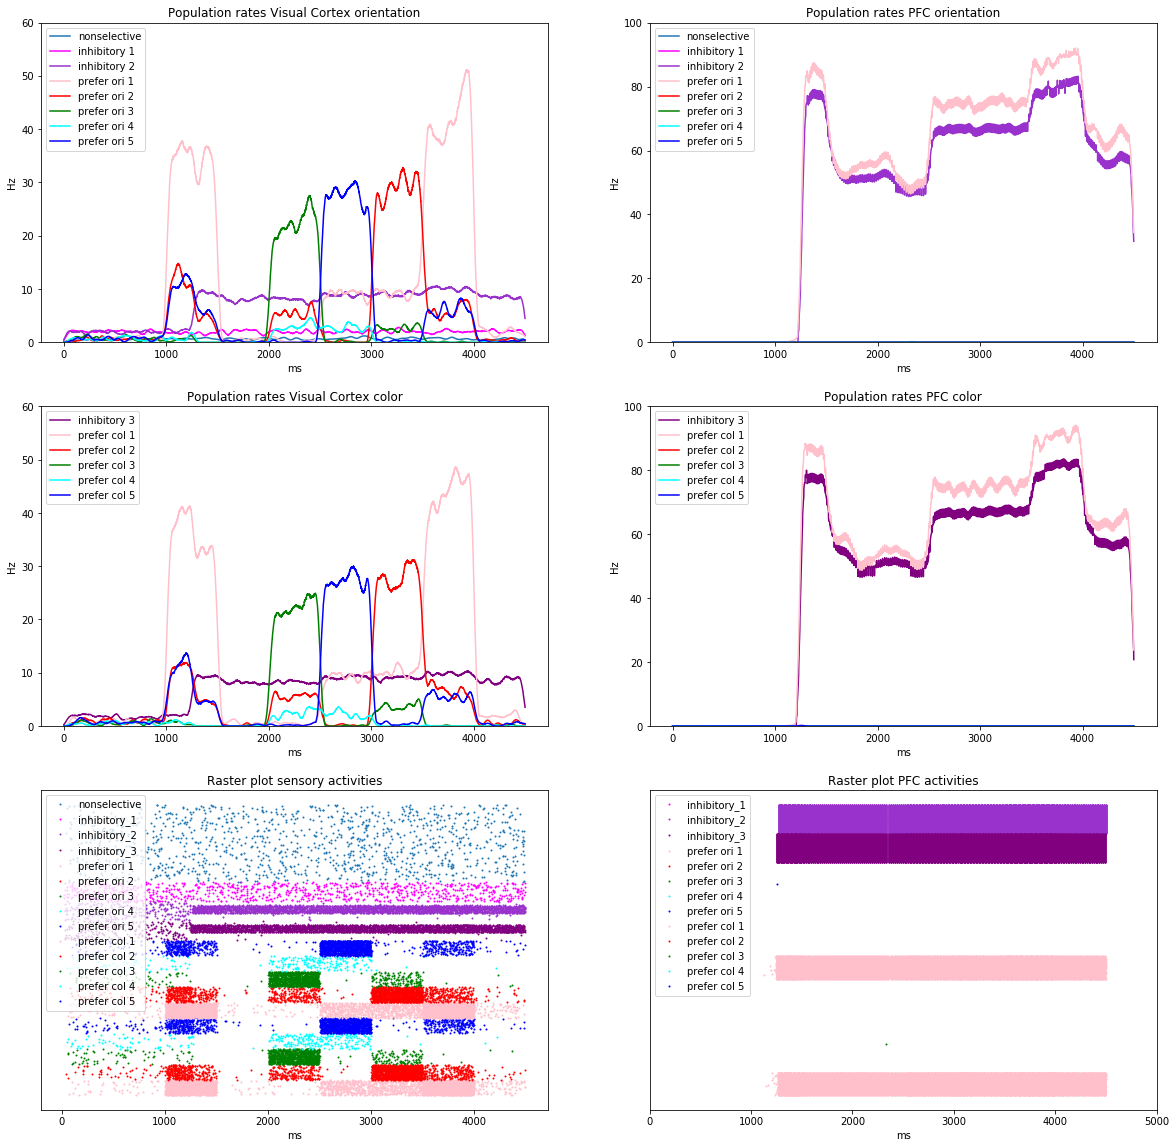

In [15]:
#for opg in range(10):
#net.restore()
nb_population=[0,1,2,3,4]
nbr_stimulus = 5

C_selection = N_sub_sub #80 neurons poisson
step = 10 * ms
rate_input = 10 * Hz

population_sélectioné_1 = choice(nb_population)
nb_population.remove(population_sélectioné_1)
print(population_sélectioné_1)

# at 1s, stimuli 1 
stimuli1_select = TimedArray(np.r_[np.zeros(100), np.ones(50), np.zeros(10)], dt=step)
stimuli1_midselect = TimedArray(np.r_[np.zeros(100), np.array([0.5]*50), np.zeros(10)], dt=step)

input1_select_col = PoissonInput(S_E_CO[population_sélectioné_1 * N_sub_sub: (population_sélectioné_1+1) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli1_select(t)')
input1_select_or = PoissonInput(S_E_OR[population_sélectioné_1 * N_sub_sub: (population_sélectioné_1+1) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli1_select(t)')

if population_sélectioné_1+1 > 4 :
    input1_midselect1_col = PoissonInput(S_E_CO[ 0: N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli1_midselect(t)')
    input1_midselect1_or = PoissonInput(S_E_OR[ 0: N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli1_midselect(t)')
else:
    input1_midselect1_col = PoissonInput(S_E_CO[ (population_sélectioné_1+1) * N_sub_sub: (population_sélectioné_1+2) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli1_midselect(t)')
    input1_midselect1_or = PoissonInput(S_E_OR[ (population_sélectioné_1+1) * N_sub_sub: (population_sélectioné_1+2) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli1_midselect(t)')

if population_sélectioné_1-1 == -1 :
    input1_midselect2_col = PoissonInput(S_E_CO[4 * N_sub_sub: 5 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli1_midselect(t)')
    input1_midselect2_or = PoissonInput(S_E_OR[4 * N_sub_sub: 5 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli1_midselect(t)')
else:
    input1_midselect2_col = PoissonInput(S_E_CO[ (population_sélectioné_1-1) * N_sub_sub: population_sélectioné_1 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli1_midselect(t)')
    input1_midselect2_or = PoissonInput(S_E_OR[ (population_sélectioné_1-1) * N_sub_sub: population_sélectioné_1 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli1_midselect(t)')

net.add(input1_select_col)
net.add(input1_midselect1_col)
net.add(input1_midselect2_col)
net.add(input1_select_or)
net.add(input1_midselect1_or)
net.add(input1_midselect2_or)


population_sélectioné_2 = choice(nb_population)
nb_population.remove(population_sélectioné_2)
print(population_sélectioné_2)

# at 2s, stimuli 2 
stimuli2_select = TimedArray(np.r_[np.zeros(200), np.ones(50), np.zeros(10)], dt=step)
stimuli2_midselect = TimedArray(np.r_[np.zeros(200), np.array([0.5]*50), np.zeros(10)], dt=step)

input2_select_col = PoissonInput(S_E_CO[population_sélectioné_2 * N_sub_sub: (population_sélectioné_2+1) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli2_select(t)')
input2_select_or = PoissonInput(S_E_OR[population_sélectioné_2 * N_sub_sub: (population_sélectioné_2+1) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli2_select(t)')

if population_sélectioné_2+1 > 4 :
    input2_midselect1_col = PoissonInput(S_E_CO[ 0: N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli2_midselect(t)')
    input2_midselect1_or = PoissonInput(S_E_OR[ 0: N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli2_midselect(t)')
else:
    input2_midselect1_col = PoissonInput(S_E_CO[ (population_sélectioné_2+1) * N_sub_sub: (population_sélectioné_2+2) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli2_midselect(t)')
    input2_midselect1_or = PoissonInput(S_E_OR[ (population_sélectioné_2+1) * N_sub_sub: (population_sélectioné_2+2) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli2_midselect(t)')

if population_sélectioné_2-1 == -1 :
    input2_midselect2_col = PoissonInput(S_E_CO[4 * N_sub_sub: 5 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli2_midselect(t)')
    input2_midselect2_or = PoissonInput(S_E_OR[4 * N_sub_sub: 5 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli2_midselect(t)')
else:
    input2_midselect2_col = PoissonInput(S_E_CO[ (population_sélectioné_2-1) * N_sub_sub: population_sélectioné_2 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli2_midselect(t)')
    input2_midselect2_or = PoissonInput(S_E_OR[ (population_sélectioné_2-1) * N_sub_sub: population_sélectioné_2 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli2_midselect(t)')

net.add(input2_select_col)
net.add(input2_midselect1_col)
net.add(input2_midselect2_col)
net.add(input2_select_or)
net.add(input2_midselect1_or)
net.add(input2_midselect2_or)

if nbr_stimulus == 3:
    # at 2.5s, stimuli 3
    stimuli3_select = TimedArray(np.r_[np.zeros(250), np.ones(50), np.zeros(10)], dt=step)
    stimuli3_midselect = TimedArray(np.r_[np.zeros(250), np.array([0.5]*50), np.zeros(10)], dt=step)

    input3_select_col = PoissonInput(S_E_CO[population_sélectioné_1 * N_sub_sub: (population_sélectioné_1+1) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli3_select(t)')
    input3_select_or = PoissonInput(S_E_OR[population_sélectioné_1 * N_sub_sub: (population_sélectioné_1+1) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli3_select(t)')

    if population_sélectioné_1+1 > 4 :
        input3_midselect1_col = PoissonInput(S_E_CO[ 0: N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli3_midselect(t)')
        input3_midselect1_or = PoissonInput(S_E_OR[ 0: N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli3_midselect(t)')
    else:
        input3_midselect1_col = PoissonInput(S_E_CO[ (population_sélectioné_1+1) * N_sub_sub: (population_sélectioné_1+2) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli3_midselect(t)')
        input3_midselect1_or = PoissonInput(S_E_OR[ (population_sélectioné_1+1) * N_sub_sub: (population_sélectioné_1+2) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli3_midselect(t)')

    if population_sélectioné_1-1 == -1 :
        input3_midselect2_col = PoissonInput(S_E_CO[4 * N_sub_sub: 5 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli3_midselect(t)')
        input3_midselect2_or = PoissonInput(S_E_OR[4 * N_sub_sub: 5 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli3_midselect(t)')
    else:
        input3_midselect2_col = PoissonInput(S_E_CO[ (population_sélectioné_1-1) * N_sub_sub: population_sélectioné_1 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli3_midselect(t)')
        input3_midselect2_or = PoissonInput(S_E_OR[ (population_sélectioné_1-1) * N_sub_sub: population_sélectioné_1 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli3_midselect(t)')

    net.add(input3_select_col)
    net.add(input3_midselect1_col)
    net.add(input3_midselect2_col)
    net.add(input3_select_or)
    net.add(input3_midselect1_or)
    net.add(input3_midselect2_or)

elif nbr_stimulus > 3:
    population_sélectioné_3 = choice(nb_population)
    nb_population.remove(population_sélectioné_3)
    print(population_sélectioné_3)

    # at 2.5s, stimuli 3 
    stimuli3_select = TimedArray(np.r_[np.zeros(250), np.ones(50), np.zeros(10)], dt=step)
    stimuli3_midselect = TimedArray(np.r_[np.zeros(250), np.array([0.5]*50), np.zeros(10)], dt=step)

    input3_select_col = PoissonInput(S_E_CO[population_sélectioné_3 * N_sub_sub: (population_sélectioné_3+1) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli3_select(t)')
    input3_select_or = PoissonInput(S_E_OR[population_sélectioné_3 * N_sub_sub: (population_sélectioné_3+1) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli3_select(t)')

    if population_sélectioné_3+1 > 4 :
        input3_midselect1_col = PoissonInput(S_E_CO[ 0: N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli3_midselect(t)')
        input3_midselect1_or = PoissonInput(S_E_OR[ 0: N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli3_midselect(t)')
    else:
        input3_midselect1_col = PoissonInput(S_E_CO[ (population_sélectioné_3+1) * N_sub_sub: (population_sélectioné_3+2) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli3_midselect(t)')
        input3_midselect1_or = PoissonInput(S_E_OR[ (population_sélectioné_3+1) * N_sub_sub: (population_sélectioné_3+2) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli3_midselect(t)')

    if population_sélectioné_3-1 == -1 :
        input3_midselect2_col = PoissonInput(S_E_CO[4 * N_sub_sub: 5 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli3_midselect(t)')
        input3_midselect2_or = PoissonInput(S_E_OR[4 * N_sub_sub: 5 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli3_midselect(t)')
    else:
        input3_midselect2_col = PoissonInput(S_E_CO[ (population_sélectioné_3-1) * N_sub_sub: population_sélectioné_3 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli3_midselect(t)')
        input3_midselect2_or = PoissonInput(S_E_OR[ (population_sélectioné_3-1) * N_sub_sub: population_sélectioné_3 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli3_midselect(t)')

    net.add(input3_select_col)
    net.add(input3_midselect1_col)
    net.add(input3_midselect2_col)
    net.add(input3_select_or)
    net.add(input3_midselect1_or)
    net.add(input3_midselect2_or)

if nbr_stimulus == 4:    
    # at 3s, stimuli 4 
    stimuli4_select = TimedArray(np.r_[np.zeros(300), np.ones(50), np.zeros(10)], dt=step)
    stimuli4_midselect = TimedArray(np.r_[np.zeros(300), np.array([0.5]*50), np.zeros(10)], dt=step)

    input4_select_col = PoissonInput(S_E_CO[population_sélectioné_1 * N_sub_sub: (population_sélectioné_1+1) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli4_select(t)')
    input4_select_or = PoissonInput(S_E_OR[population_sélectioné_1 * N_sub_sub: (population_sélectioné_1+1) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli4_select(t)')

    if population_sélectioné_1+1 > 4 :
        input4_midselect1_col = PoissonInput(S_E_CO[ 0: N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli4_midselect(t)')
        input4_midselect1_or = PoissonInput(S_E_OR[ 0: N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli4_midselect(t)')
    else:
        input4_midselect1_col = PoissonInput(S_E_CO[ (population_sélectioné_1+1) * N_sub_sub: (population_sélectioné_1+2) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli4_midselect(t)')
        input4_midselect1_or = PoissonInput(S_E_OR[ (population_sélectioné_1+1) * N_sub_sub: (population_sélectioné_1+2) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli4_midselect(t)')

    if population_sélectioné_1-1 == -1 :
        input4_midselect2_col = PoissonInput(S_E_CO[4 * N_sub_sub: 5 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli4_midselect(t)')
        input4_midselect2_or = PoissonInput(S_E_OR[4 * N_sub_sub: 5 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli4_midselect(t)')
    else:
        input4_midselect2_col = PoissonInput(S_E_CO[ (population_sélectioné_1-1) * N_sub_sub: population_sélectioné_1 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli4_midselect(t)')
        input4_midselect2_or = PoissonInput(S_E_OR[ (population_sélectioné_1-1) * N_sub_sub: population_sélectioné_1 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli4_midselect(t)')

    net.add(input4_select_col)
    net.add(input4_midselect1_col)
    net.add(input4_midselect2_col)
    net.add(input4_select_or)
    net.add(input4_midselect1_or)
    net.add(input4_midselect2_or)

elif nbr_stimulus > 4: 
    population_sélectioné_4 = choice(nb_population)
    nb_population.remove(population_sélectioné_4)
    print(population_sélectioné_4)

    # at 3s, stimuli 4 
    stimuli4_select = TimedArray(np.r_[np.zeros(300), np.ones(50), np.zeros(10)], dt=step)
    stimuli4_midselect = TimedArray(np.r_[np.zeros(300), np.array([0.5]*50), np.zeros(10)], dt=step)

    input4_select_col = PoissonInput(S_E_CO[population_sélectioné_4 * N_sub_sub: (population_sélectioné_4+1) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli4_select(t)')
    input4_select_or = PoissonInput(S_E_OR[population_sélectioné_4 * N_sub_sub: (population_sélectioné_4+1) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli4_select(t)')

    if population_sélectioné_4+1 > 4 :
        input4_midselect1_col = PoissonInput(S_E_CO[ 0: N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli4_midselect(t)')
        input4_midselect1_or = PoissonInput(S_E_OR[ 0: N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli4_midselect(t)')
    else:
        input4_midselect1_col = PoissonInput(S_E_CO[ (population_sélectioné_4+1) * N_sub_sub: (population_sélectioné_4+2) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli4_midselect(t)')
        input4_midselect1_or = PoissonInput(S_E_OR[ (population_sélectioné_4+1) * N_sub_sub: (population_sélectioné_4+2) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli4_midselect(t)')

    if population_sélectioné_4-1 == -1 :
        input4_midselect2_col = PoissonInput(S_E_CO[4 * N_sub_sub: 5 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli4_midselect(t)')
        input4_midselect2_or = PoissonInput(S_E_OR[4 * N_sub_sub: 5 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli4_midselect(t)')
    else:
        input4_midselect2_col = PoissonInput(S_E_CO[ (population_sélectioné_4-1) * N_sub_sub: population_sélectioné_4 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli4_midselect(t)')
        input4_midselect2_or = PoissonInput(S_E_OR[ (population_sélectioné_4-1) * N_sub_sub: population_sélectioné_4 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli4_midselect(t)')

    net.add(input4_select_col)
    net.add(input4_midselect1_col)
    net.add(input4_midselect2_col)
    net.add(input4_select_or)
    net.add(input4_midselect1_or)
    net.add(input4_midselect2_or) 

if nbr_stimulus == 5:     
    # at 3.5s, stimuli 5 
    stimuli5_select = TimedArray(np.r_[np.zeros(350), np.ones(50), np.zeros(10)], dt=step)
    stimuli5_midselect = TimedArray(np.r_[np.zeros(350), np.array([0.5]*50), np.zeros(10)], dt=step)

    input5_select_col = PoissonInput(S_E_CO[population_sélectioné_1 * N_sub_sub: (population_sélectioné_1+1) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli5_select(t)')
    input5_select_or = PoissonInput(S_E_OR[population_sélectioné_1 * N_sub_sub: (population_sélectioné_1+1) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli5_select(t)')

    if population_sélectioné_1+1 > 4 :
        input5_midselect1_col = PoissonInput(S_E_CO[ 0: N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli5_midselect(t)')
        input5_midselect1_or = PoissonInput(S_E_OR[ 0: N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli5_midselect(t)')
    else:
        input5_midselect1_col = PoissonInput(S_E_CO[ (population_sélectioné_1+1) * N_sub_sub: (population_sélectioné_1+2) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli5_midselect(t)')
        input5_midselect1_or = PoissonInput(S_E_OR[ (population_sélectioné_1+1) * N_sub_sub: (population_sélectioné_1+2) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli5_midselect(t)')

    if population_sélectioné_1-1 == -1 :
        input5_midselect2_col = PoissonInput(S_E_CO[4 * N_sub_sub: 5 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli5_midselect(t)')
        input5_midselect2_or = PoissonInput(S_E_OR[4 * N_sub_sub: 5 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli5_midselect(t)')
    else:
        input5_midselect2_col = PoissonInput(S_E_CO[ (population_sélectioné_1-1) * N_sub_sub: population_sélectioné_1 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli5_midselect(t)')
        input5_midselect2_or = PoissonInput(S_E_OR[ (population_sélectioné_1-1) * N_sub_sub: population_sélectioné_1 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli5_midselect(t)')

    net.add(input5_select_col)
    net.add(input5_midselect1_col)
    net.add(input5_midselect2_col)
    net.add(input5_select_or)
    net.add(input5_midselect1_or)
    net.add(input5_midselect2_or)

elif nbr_stimulus > 5:
    population_sélectioné_5 = choice(nb_population)
    nb_population.remove(population_sélectioné_5)
    print(population_sélectioné_5)

    # at 3.5s, stimuli 5
    stimuli5_select = TimedArray(np.r_[np.zeros(350), np.ones(50), np.zeros(10)], dt=step)
    stimuli5_midselect = TimedArray(np.r_[np.zeros(350), np.array([0.5]*50), np.zeros(10)], dt=step)

    input5_select_col = PoissonInput(S_E_CO[population_sélectioné_5 * N_sub_sub: (population_sélectioné_5+1) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli5_select(t)')
    input5_select_or = PoissonInput(S_E_OR[population_sélectioné_5 * N_sub_sub: (population_sélectioné_5+1) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli5_select(t)')

    if population_sélectioné_5+1 > 4 :
        input5_midselect1_col = PoissonInput(S_E_CO[ 0: N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli5_midselect(t)')
        input5_midselect1_or = PoissonInput(S_E_OR[ 0: N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli5_midselect(t)')
    else:
        input5_midselect1_col = PoissonInput(S_E_CO[ (population_sélectioné_5+1) * N_sub_sub: (population_sélectioné_5+2) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli5_midselect(t)')
        input5_midselect1_or = PoissonInput(S_E_OR[ (population_sélectioné_5+1) * N_sub_sub: (population_sélectioné_5+2) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli5_midselect(t)')

    if population_sélectioné_5-1 == -1 :
        input5_midselect2_col = PoissonInput(S_E_CO[4 * N_sub_sub: 5 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli5_midselect(t)')
        input5_midselect2_or = PoissonInput(S_E_OR[4 * N_sub_sub: 5 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli5_midselect(t)')
    else:
        input5_midselect2_col = PoissonInput(S_E_CO[ (population_sélectioné_5-1) * N_sub_sub: population_sélectioné_5 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli5_midselect(t)')
        input5_midselect2_or = PoissonInput(S_E_OR[ (population_sélectioné_5-1) * N_sub_sub: population_sélectioné_5 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli5_midselect(t)')

    net.add(input5_select_col)
    net.add(input5_midselect1_col)
    net.add(input5_midselect2_col)
    net.add(input5_select_or)
    net.add(input5_midselect1_or)
    net.add(input5_midselect2_or)

if nbr_stimulus == 6:
    # at 4.5s, stimuli 6
    stimuli6_select = TimedArray(np.r_[np.zeros(400), np.ones(50), np.zeros(10)], dt=step)
    stimuli6_midselect = TimedArray(np.r_[np.zeros(400), np.array([0.5]*50), np.zeros(10)], dt=step)

    input6_select_col = PoissonInput(S_E_CO[population_sélectioné_1 * N_sub_sub: (population_sélectioné_1+1) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli6_select(t)')
    input6_select_or = PoissonInput(S_E_OR[population_sélectioné_1 * N_sub_sub: (population_sélectioné_1+1) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli6_select(t)')

    if population_sélectioné_1+1 == 5 :
        input6_midselect1_col = PoissonInput(S_E_CO[ 0: N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli6_midselect(t)')
        input6_midselect1_or = PoissonInput(S_E_OR[ 0: N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli6_midselect(t)')
    else:
        input6_midselect1_col = PoissonInput(S_E_CO[ (population_sélectioné_1+1) * N_sub_sub: (population_sélectioné_1+2) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli6_midselect(t)')
        input6_midselect1_or = PoissonInput(S_E_OR[ (population_sélectioné_1+1) * N_sub_sub: (population_sélectioné_1+2) * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli6_midselect(t)')

    if population_sélectioné_1-1 == -1 :
        input6_midselect2_col = PoissonInput(S_E_CO[4 * N_sub_sub: 5 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli6_midselect(t)')
        input6_midselect2_or = PoissonInput(S_E_OR[4 * N_sub_sub: 5 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli6_midselect(t)')
    else:
        input6_midselect2_col = PoissonInput(S_E_CO[ (population_sélectioné_1-1) * N_sub_sub: population_sélectioné_1 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli6_midselect(t)')
        input6_midselect2_or = PoissonInput(S_E_OR[ (population_sélectioné_1-1) * N_sub_sub: population_sélectioné_1 * N_sub_sub], 's_AMPA_ext', C_selection, rate_input, 'stimuli6_midselect(t)')

    net.add(input6_select_col)
    net.add(input6_midselect1_col)
    net.add(input6_midselect2_col)
    net.add(input6_select_or)
    net.add(input6_midselect1_or)
    net.add(input6_midselect2_or)

print('le nombre de stimulus est ',nbr_stimulus)

net.run((3.5+(0.5*(nbr_stimulus-3))) * second)


figure(figsize=(20,20))
subplot(3,2,1)
title('Population rates Visual Cortex orientation')
xlabel('ms')
ylabel('Hz')
ylim(0,60)

plot(r_S_E.t / ms, r_S_E.smooth_rate(width=25 * ms) / Hz, label='nonselective')
plot(r_S_I_1.t / ms, r_S_I_1.smooth_rate(width=25 * ms) / Hz, label='inhibitory 1', color = 'magenta')
plot(r_S_I_2.t / ms, r_S_I_2.smooth_rate(width=25 * ms) / Hz, label='inhibitory 2', color = 'darkorchid')


plot(r_S_E_sel_orien_1.t / ms, r_S_E_sel_orien_1.smooth_rate(width=25 * ms) / Hz, label='prefer ori 1 ',color ='pink')
plot(r_S_E_sel_orien_2.t / ms, r_S_E_sel_orien_2.smooth_rate(width=25 * ms) / Hz, label='prefer ori 2 ',color ='red')
plot(r_S_E_sel_orien_3.t / ms, r_S_E_sel_orien_3.smooth_rate(width=25 * ms) / Hz, label='prefer ori 3 ',color ='green')
plot(r_S_E_sel_orien_4.t / ms, r_S_E_sel_orien_4.smooth_rate(width=25 * ms) / Hz, label='prefer ori 4 ',color ='cyan')
plot(r_S_E_sel_orien_5.t / ms, r_S_E_sel_orien_5.smooth_rate(width=25 * ms) / Hz, label='prefer ori 5 ',color ='blue')
legend()

subplot(3,2,2)
title('Population rates PFC orientation')
xlabel('ms')
ylabel('Hz')
ylim(0,100)
plot(r_E.t / ms, r_E.smooth_rate(width=25 * ms) / Hz, label='nonselective')
plot(r_I_1.t / ms, r_I_1.smooth_rate(width=25 * ms) / Hz, label='inhibitory 1', color = 'magenta')
plot(r_I_2.t / ms, r_I_2.smooth_rate(width=25 * ms) / Hz, label='inhibitory 2', color = 'darkorchid')


plot(r_E_sel_orien_1.t / ms, r_E_sel_orien_1.smooth_rate(width=25 * ms) / Hz, label='prefer ori 1 ',color ='pink')
plot(r_E_sel_orien_2.t / ms, r_E_sel_orien_2.smooth_rate(width=25 * ms) / Hz, label='prefer ori 2 ',color ='red')
plot(r_E_sel_orien_3.t / ms, r_E_sel_orien_3.smooth_rate(width=25 * ms) / Hz, label='prefer ori 3 ',color ='green')
plot(r_E_sel_orien_4.t / ms, r_E_sel_orien_4.smooth_rate(width=25 * ms) / Hz, label='prefer ori 4 ',color ='cyan')
plot(r_E_sel_orien_5.t / ms, r_E_sel_orien_5.smooth_rate(width=25 * ms) / Hz, label='prefer ori 5 ',color ='blue')

legend()

subplot(3,2,3)
title('Population rates Visual Cortex color')
xlabel('ms')
ylabel('Hz')
ylim(0,60)
plot(r_S_I_3.t / ms, r_S_I_3.smooth_rate(width=25 * ms) / Hz, label='inhibitory 3', color = 'purple')
plot(r_S_E_sel_col_1.t / ms, r_S_E_sel_col_1.smooth_rate(width=25 * ms) / Hz, label='prefer col 1',color ='pink')
plot(r_S_E_sel_col_2.t / ms, r_S_E_sel_col_2.smooth_rate(width=25 * ms) / Hz, label='prefer col 2',color ='red')
plot(r_S_E_sel_col_3.t / ms, r_S_E_sel_col_3.smooth_rate(width=25 * ms) / Hz, label='prefer col 3',color ='green')
plot(r_S_E_sel_col_4.t / ms, r_S_E_sel_col_4.smooth_rate(width=25 * ms) / Hz, label='prefer col 4',color ='cyan')
plot(r_S_E_sel_col_5.t / ms, r_S_E_sel_col_5.smooth_rate(width=25 * ms) / Hz, label='prefer col 5',color ='blue')

legend()

subplot(3,2,4)
title('Population rates PFC color')
xlabel('ms')
ylabel('Hz')
ylim(0,100)
plot(r_I_3.t / ms, r_I_3.smooth_rate(width=25 * ms) / Hz, label='inhibitory 3', color = 'purple')
plot(r_E_sel_col_1.t / ms, r_E_sel_col_1.smooth_rate(width=25 * ms) / Hz, label='prefer col 1',color ='pink')
plot(r_E_sel_col_2.t / ms, r_E_sel_col_2.smooth_rate(width=25 * ms) / Hz, label='prefer col 2',color ='red')
plot(r_E_sel_col_3.t / ms, r_E_sel_col_3.smooth_rate(width=25 * ms) / Hz, label='prefer col 3',color ='green')
plot(r_E_sel_col_4.t / ms, r_E_sel_col_4.smooth_rate(width=25 * ms) / Hz, label='prefer col 4',color ='cyan')
plot(r_E_sel_col_5.t / ms, r_E_sel_col_5.smooth_rate(width=25 * ms) / Hz, label='prefer col 5',color ='blue')

legend()

subplot(3,2,5)
title('Raster plot sensory activities')
xlabel('ms')
yticks([])

plot(sp_S_E.t / ms, sp_S_E.i + 10 * N_sub_sub + sub_N_I * 3, '.', markersize=2, label='nonselective')
plot(sp_S_I_1.t / ms, sp_S_I_1.i + 10 * N_sub_sub + sub_N_I * 2, '.', markersize=2, label='inhibitory_1',color = 'magenta')
plot(sp_S_I_2.t / ms, sp_S_I_2.i + 10 * N_sub_sub + sub_N_I, '.', markersize=2, label='inhibitory_2',color = 'darkorchid')
plot(sp_S_I_3.t / ms, sp_S_I_3.i + 10 * N_sub_sub, '.', markersize=2, label='inhibitory_3',color = 'purple')

plot(sp_S_E_sel_orien_1.t / ms, sp_S_E_sel_orien_1.i, '.', markersize=2, label='prefer ori 1 ',color ='pink')
plot(sp_S_E_sel_orien_2.t / ms, sp_S_E_sel_orien_2.i + N_sub_sub, '.', markersize=2, label='prefer ori 2 ',color ='red')
plot(sp_S_E_sel_orien_3.t / ms, sp_S_E_sel_orien_3.i + 2 * N_sub_sub, '.', markersize=2, label='prefer ori 3 ',color ='green')
plot(sp_S_E_sel_orien_4.t / ms, sp_S_E_sel_orien_4.i + 3 * N_sub_sub, '.', markersize=2,label='prefer ori 4 ',color ='cyan')
plot(sp_S_E_sel_orien_5.t / ms, sp_S_E_sel_orien_5.i + 4 * N_sub_sub, '.', markersize=2, label='prefer ori 5 ',color ='blue')

plot(sp_S_E_sel_col_1.t / ms, sp_S_E_sel_col_1.i + 5 * N_sub_sub, '.', markersize=2, label='prefer col 1',color ='pink')
plot(sp_S_E_sel_col_2.t / ms, sp_S_E_sel_col_2.i + 6 * N_sub_sub, '.', markersize=2, label='prefer col 2',color ='red')
plot(sp_S_E_sel_col_3.t / ms, sp_S_E_sel_col_3.i + 7 * N_sub_sub, '.', markersize=2, label='prefer col 3',color ='green')
plot(sp_S_E_sel_col_4.t / ms, sp_S_E_sel_col_4.i + 8 * N_sub_sub, '.', markersize=2, label='prefer col 4',color ='cyan')
plot(sp_S_E_sel_col_5.t / ms, sp_S_E_sel_col_5.i + 9 * N_sub_sub, '.', markersize=2, label='prefer col 5',color ='blue')

legend()


subplot(3,2,6)
title('Raster plot PFC activities')
xlabel('ms')
yticks([])
xlim(0,5000)

try:
    plot(sp_E.t / ms, sp_S_E.i + 10 * N_sub_sub + sub_N_I * 3, '.', markersize=2, label='nonselective')
except :
    print ("pas de spike PFC non selectif")
plot(sp_I_1.t / ms, sp_I_1.i + 10 * N_sub_sub + sub_N_I * 2, '.', markersize=2, label='inhibitory_1',color = 'magenta')
plot(sp_I_2.t / ms, sp_I_2.i + 10 * N_sub_sub + sub_N_I, '.', markersize=2, label='inhibitory_2',color = 'darkorchid')
plot(sp_I_3.t / ms, sp_I_3.i + 10 * N_sub_sub, '.', markersize=2, label='inhibitory_3',color = 'purple')

plot(sp_E_sel_orien_1.t / ms, sp_E_sel_orien_1.i, '.', markersize=2, label='prefer ori 1 ',color ='pink')
plot(sp_E_sel_orien_2.t / ms, sp_E_sel_orien_2.i + N_sub_sub, '.', markersize=2, label='prefer ori 2 ',color ='red')
plot(sp_E_sel_orien_3.t / ms, sp_E_sel_orien_3.i + 2 * N_sub_sub, '.', markersize=2, label='prefer ori 3 ',color ='green')
plot(sp_E_sel_orien_4.t / ms, sp_E_sel_orien_4.i + 3 * N_sub_sub, '.', markersize=2,label='prefer ori 4 ',color ='cyan')
plot(sp_E_sel_orien_5.t / ms, sp_E_sel_orien_5.i + 4 * N_sub_sub, '.', markersize=2, label='prefer ori 5 ',color ='blue')

plot(sp_E_sel_col_1.t / ms, sp_E_sel_col_1.i + 5 * N_sub_sub, '.', markersize=2, label='prefer col 1',color ='pink')
plot(sp_E_sel_col_2.t / ms, sp_E_sel_col_2.i + 6 * N_sub_sub, '.', markersize=2, label='prefer col 2',color ='red')
plot(sp_E_sel_col_3.t / ms, sp_E_sel_col_3.i + 7 * N_sub_sub, '.', markersize=2, label='prefer col 3',color ='green')
plot(sp_E_sel_col_4.t / ms, sp_E_sel_col_4.i + 8 * N_sub_sub, '.', markersize=2, label='prefer col 4',color ='cyan')
plot(sp_E_sel_col_5.t / ms, sp_E_sel_col_5.i + 9 * N_sub_sub, '.', markersize=2, label='prefer col 5',color ='blue')

legend()
show()